# Backprop autograd

Using micrograd https://github.com/karpathy/micrograd

## Derivative basics

$$
f'(x) = \frac{d}{dx}f(x)
$$

Numerical approximation

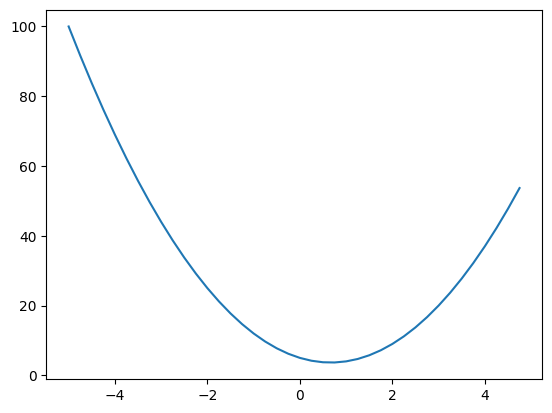

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
  return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
# derivada de un solo input 

h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [24]:
print(f'partial derivative of d wrt a:')
print('d = a*b + c')
print('d/da = b')

h = 0.0001
print(f'\nh = {h}')

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # d al punto a
a_new = a + h
d2 = a_new*b + c # d al punto a+h

print('--------------------------------')
print(f'\na original:', a)
print('d1', d1)
print(f'\na+h:', a_new)
print('d2', d2)
print('\nslope (d2 - d1)/h =', (d2 - d1)/h)
print(f'b original:', b)

partial derivative of d wrt a:
d = a*b + c
d/da = b

h = 0.0001
--------------------------------

a original: 2.0
d1 4.0

a+h: 2.0001
d2 3.999699999999999

slope (d2 - d1)/h = -3.000000000010772
b original: -3.0


In [25]:
print(f'partial derivative of d wrt b:')
print('d = a*b + c')
print('d/db = a')

h = 0.0001
print(f'\nh = {h}')

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b_new = b + h
d2 = a*b_new + c

print('--------------------------------')
print(f'\nb original:', b)
print('d1', d1)
print(f'\nb+h:', b_new)
print('d2', d2)
print('\nslope (d2 - d1)/h =', (d2 - d1)/h)
print(f'a original:', a)

partial derivative of d wrt b:
d = a*b + c
d/db = a

h = 0.0001
--------------------------------

b original: -3.0
d1 4.0

b+h: -2.9999
d2 4.0002

slope (d2 - d1)/h = 2.0000000000042206
a original: 2.0


In [26]:
print(f'partial derivative of d wrt c:')
print('d = a*b + c')
print('d/dc = 1')

h = 0.0001
print(f'\nh = {h}')

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c_new = c + h
d2 = a*b + c_new

print('--------------------------------')
print(f'\nc original:', c)
print('d1', d1)
print(f'\nc+h:', c_new)
print('d2', d2)
print('\nslope (d2 - d1)/h =', (d2 - d1)/h)

partial derivative of d wrt c:
d = a*b + c
d/dc = 1

h = 0.0001
--------------------------------

c original: 10.0
d1 4.0

c+h: 10.0001
d2 4.0001

slope (d2 - d1)/h = 0.9999999999976694


## Operations graph basics

In [27]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data # numerical value 
        self._prev = set(_children) # the set of immediate predecessors
        self._op = _op # the operation

    def __repr__(self):
        return f"Value(data={self.data})"   
    

    ## Operations
    
    def __add__(self, other):
        """
        Addition operation
        other: Value (other value to add to self)
        """
        out = Value( 
            data = self.data + other.data, # addition
            _children = (self, other), # it saves the components of the operation
            _op = "+"
            ) 
        return out
    
    def __mul__(self, other):
        """
        Multiplication operation
        other: Value (other value to multiply to self)
        """
        out = Value( 
            data = self.data * other.data, # multiplication
            _children = (self, other), # it saves the components of the operation
            _op = "*"
            ) 
        return out

In [48]:
a = Value(2.0)
b = Value(-3.0)

c = a*b

print(f"value: {c}")
print(f"prev values: {c._prev}")
print(f'op: {c._op}')

value: Value(data=-6.0)
prev values: {Value(data=-3.0), Value(data=2.0)}
op: *


In [50]:
d = Value(10.0)

e = c + d

f = Value(-2.0)

L = e * f

print(f'a: {a} -> prev: {a._prev} -> op: {a._op}')
print(f'b: {b} -> prev: {b._prev} -> op: {b._op}')
print(f'c: {c} -> prev: {c._prev} -> op: {c._op}')
print(f'd: {d} -> prev: {d._prev} -> op: {d._op}')
print(f'e: {e} -> prev: {e._prev} -> op: {e._op}')
print(f'f: {f} -> prev: {f._prev} -> op: {f._op}')
print(f'L: {L} -> prev: {L._prev} -> op: {L._op}')

a: Value(data=2.0) -> prev: set() -> op: 
b: Value(data=-3.0) -> prev: set() -> op: 
c: Value(data=-6.0) -> prev: {Value(data=-3.0), Value(data=2.0)} -> op: *
d: Value(data=10.0) -> prev: set() -> op: 
e: Value(data=4.0) -> prev: {Value(data=-6.0), Value(data=10.0)} -> op: +
f: Value(data=-2.0) -> prev: set() -> op: 
L: Value(data=-8.0) -> prev: {Value(data=4.0), Value(data=-2.0)} -> op: *


In [51]:
# visualizar

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root, label=False):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    if label:
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    else:
        dot.node(name = uid, label = "{ data %.4f }" % (n.data, ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
        dot.node(name = uid + n._op, label = n._op)
        # and connect this node to it
        dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

e: Value(data=4.0) -> prev: {Value(data=-6.0), Value(data=10.0)} -> op: +


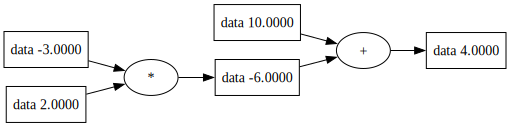

In [55]:
print(f'e: {e} -> prev: {e._prev} -> op: {e._op}')
draw_dot(e)

L: Value(data=-8.0) -> prev: {Value(data=4.0), Value(data=-2.0)} -> op: *


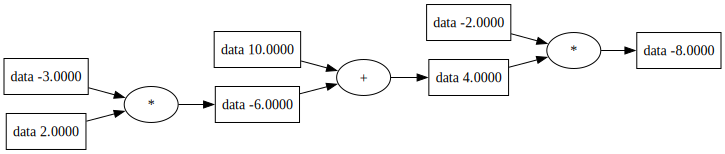

In [56]:
print(f'L: {L} -> prev: {L._prev} -> op: {L._op}')
draw_dot(L)

## Backprop basics

Se empieza del ultimo nodo y va hacia atras. Para cada uno de los valores anteriores, se computa la **derivada de ese nodo con respecto a L**.


In [75]:
# aca le agregamos: GRAD, labels y una nueva operacion (tanh)
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # local gradient
    self._backward = lambda: None # local backward
    self._prev = set(_children) # the set of immediate predecessors
    self._op = _op
    self.label = label

  def __repr__(self):
    # return f"Value({self.data}, {self.label})"
    return f"{self.label}={self.data}"
  
  # operations
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')  
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

In [76]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(f'a: {a} -> prev: {a._prev} -> op: {a._op}')
print(f'b: {b} -> prev: {b._prev} -> op: {b._op}')
print(f'c: {c} -> prev: {c._prev} -> op: {c._op}')
print(f'e: {e} -> prev: {e._prev} -> op: {e._op}')
print(f'd: {d} -> prev: {d._prev} -> op: {d._op}')
print(f'f: {f} -> prev: {f._prev} -> op: {f._op}')
print(f'L: {L} -> prev: {L._prev} -> op: {L._op}')

a: a=2.0 -> prev: set() -> op: 
b: b=-3.0 -> prev: set() -> op: 
c: c=10.0 -> prev: set() -> op: 
e: e=-6.0 -> prev: {a=2.0, b=-3.0} -> op: *
d: d=4.0 -> prev: {e=-6.0, c=10.0} -> op: +
f: f=-2.0 -> prev: set() -> op: 
L: L=-8.0 -> prev: {d=4.0, f=-2.0} -> op: *


In [80]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  dot.attr(size='15')
  return dot

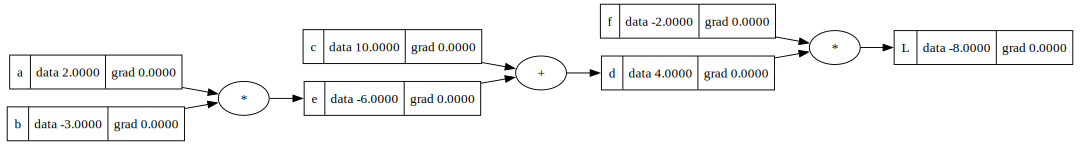

In [81]:
draw_dot(L)

**Chain Rule**

Para saber la derivada de un nodo con respecto a L, hay que calcular la derivada de ese nodo con respecto a su siguiente y asi sucesivamente multiplicandolos hasta llegar a L.


Entender dL/dc:

Si sabemos las derivadas **locales**:
- El impacto que tiene d en L (dL/dd)
- El impacto de c en d (dd/dc)

Podemos saber el impacto de c en L (dL/dc): **(dL/dd)*(dd/dc)**

$$
\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc}
$$

In [87]:
# CHEQUEAR LA DERIVADA NUMERICAMENTE (con respecto a L)
# aumentando el value del nodo por h y fijandose la diferencia con el original

def lol(node='a'):
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data # L1 is the original value of L (before the change)
  
  # changing the value of the node we're interested in (by adding h)
  a = Value(2.0, label='a')
  if node == 'a':
    a.data += h 
  b = Value(-3.0, label='b')
  if node == 'b':
    b.data += h
  c = Value(10.0, label='c')
  if node == 'c':
    c.data += h
  e = a*b; e.label = 'e'
  if node == 'e':
    e.data += h
  d = e + c; d.label = 'd'
  if node == 'd':
    d.data += h
  f = Value(-2.0, label='f')
  if node == 'f':
    f.data += h
  
  # L is the result of the operation after the change
  L = d * f; L.label = 'L'
  L2 = L.data
  
  # dL/dc = (L2 - L1)/h
  return round((L2 - L1)/h, 3)
  
lol(node='b')

for node in ['a', 'b', 'c', 'd', 'e', 'f']:
  print(f'dL/d{node} = {lol(node=node)}')

dL/da = 6.0
dL/db = -4.0
dL/dc = -2.0
dL/dd = -2.0
dL/de = -2.0
dL/df = 4.0


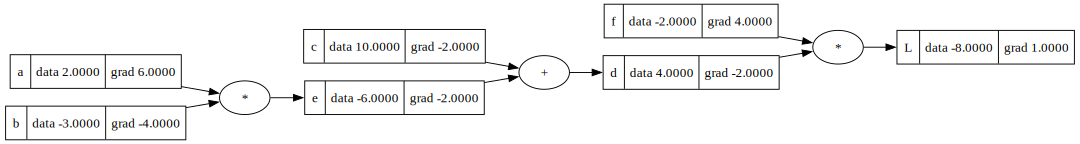

In [ ]:
# visualize the gradient of L with respect to each node

L.grad = 1.0 # is 1 because L is the last node
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
d.grad = -2.0
e.grad = -2.0
f.grad = 4.0

draw_dot(L)


Given `L = d * f` as our final output, we compute ∂L/∂x for each node x using the chain rule to backpropagate gradients.

Starting from output L
- ∂L/∂L = L.grad = 1.0 (by convention for final output)

**Direct inputs to L (d and f)**
- ∂L/∂d = 1.0 * f = 1.0 * (-2.0) = -2.0
- ∂L/∂f = 1.0 * d = 1.0 * 4.0 = 4.0

**Inputs to d (e and c)**
Since d = e + c, the derivative flows directly:
- ∂L/∂e = ∂L/∂d * ∂d/∂e = -2.0 * 1 = -2.0  
- ∂L/∂c = ∂L/∂d * ∂d/∂c = -2.0 * 1 = -2.0

**Inputs to e (a and b)**
Given e = a * b, we apply the product rule:
- ∂L/∂a = ∂L/∂e * ∂e/∂a = -2.0 * b = -2.0 * (-3.0) = 6.0
- ∂L/∂b = ∂L/∂e * ∂e/∂b = -2.0 * a = -2.0 * 2.0 = -4.0

This demonstrates backpropagation through the computation graph, where each operation applies its local derivative and the chain rule combines them to compute the total gradient ∂L/∂x for each node x.

The computation graph forms a directed acyclic graph (DAG) where:


## Optimization step 

(increasing gradient)

El **gradiente** siempre siempre apunta a la direccion del steepest ascent de una funcion.
- **Direccion** del gradiente: te dice para que lado debes ir para incrementar el valor de la funcion
- **Magnitud** del gradiente: te dice el rate de como se incrementa esa funcion si te moves en esa fdireccion

In [90]:
# si queremos aumentar el valor de L con respecto a todos, haciendo pasos chiquitos (0.01) podemos hacer:

print(L.data)

step_size = 0.01

# estos son los nodos que podemos modificar (no resultados de operaciones)
a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

# forward pass
e = a * b
d = e + c
L = d * f

print(L.data)


-8.0
-7.286496


## Neuron

En una neurona tenemos:
- inputs xs (data)
- weights (activaciones)
- biases
- activation function

### Neuron operations graph

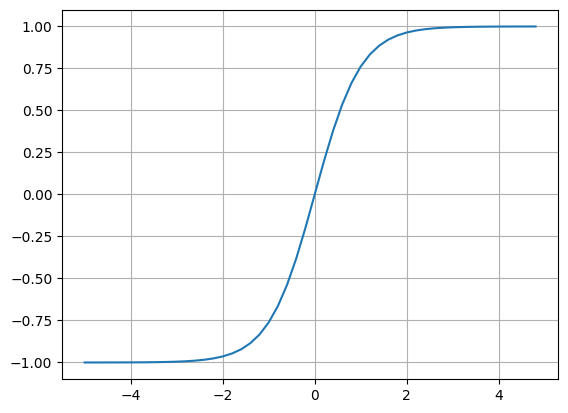

In [91]:
# TANH ACTIVATION FUNCTION
# hace un squashing de los values 

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

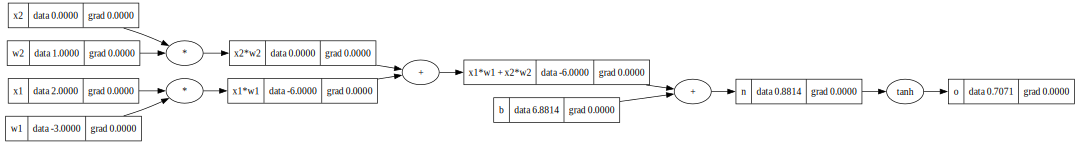

In [113]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

### Backprop 

Lo que queremos es saber las derivadas de L con respecto a los weights y biases de la neurona.

In [114]:
# BACKPROP
# create a function for each operation that tells us how to calculate the local derivative of that particular node
# we want to take out grad (the gradient of the resulting operation) and propagate it to self and other grads

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # arranca como funcion vacia
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  # operations
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    # queremos tomar out grad (el gradiente de la operacion resultante) y propagarlo para self y other grads
    def _backward():
      self.grad += 1.0 * out.grad # chain rule de la local (1.0) con el grad global de out. Se acumulan por si se usa dos veces el mismo Value
      other.grad += 1.0 * out.grad
    out._backward = _backward # funcion que propaga el gradiente. Aca estamos fijando la funcion _backward a esta particular de add
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    # queremos tomar out grad (el gradiente de la operacion resultante) y propagarlo para self y other grads
    def _backward():
      self.grad += other.data * out.grad # chain rule de la local (el otro value porque es una multiplicacion) con el grad global de out
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    # queremos tomar out grad (el gradiente de la operacion resultante) y propagarlo para self y other grads
    def _backward():
      self.grad += (1 - t**2) * out.grad # chain rule
    out._backward = _backward 
    
    return out
  
 # Esto simplemente automatiza toda la ejecucion hacia atras de los _backwards para cada nodo (usa topological sort)
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


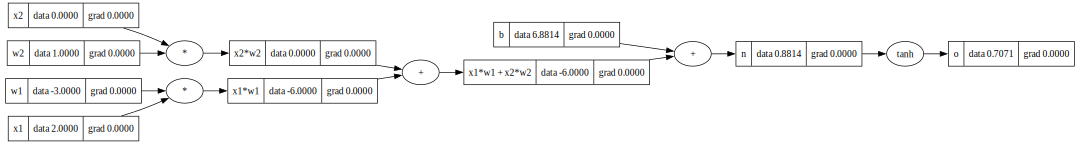

In [115]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

#### _backward a mano

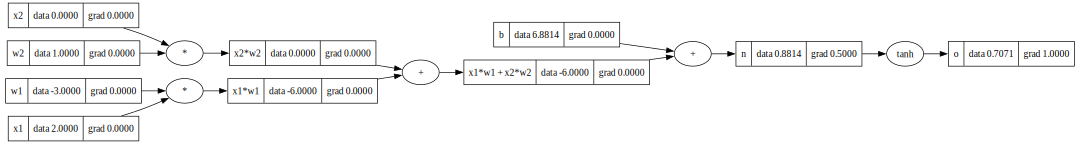

In [116]:
# inicializo a 1 porque es el ultimo nodo (todo lo demas queda en 0)
o.grad = 1.0 

# con esto calculo el grad de n (tanh que viene antes de o)
o._backward()

draw_dot(o)

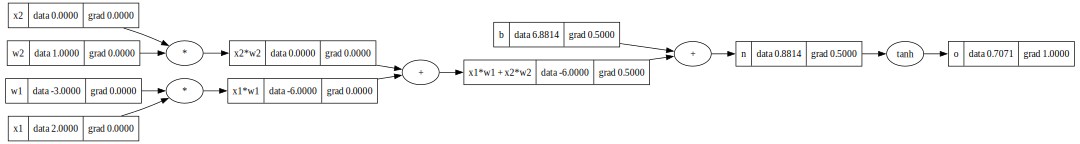

In [117]:
# with this I calculate the grad of o wrt b and w1*w1+x2*w2
n._backward()
b._backward()

draw_dot(o)

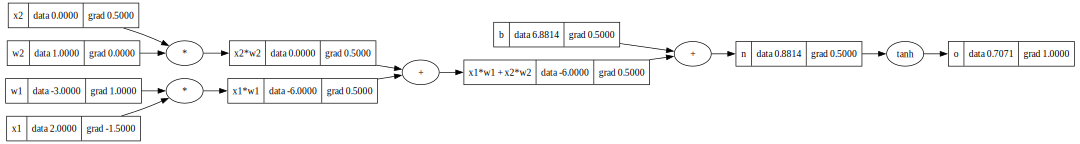

In [118]:
x1w1x2w2._backward()

x2w2._backward()
x1w1._backward()

draw_dot(o)

#### backward automatico

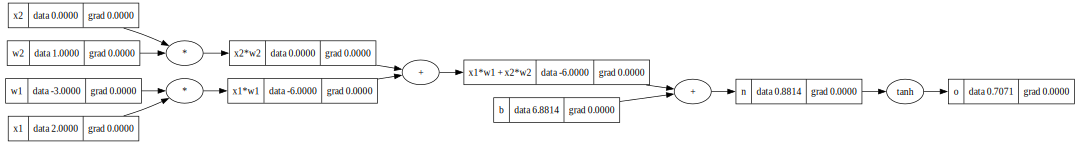

In [119]:
# inicializo todo

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

topo: [Value(data=6.881373587019543), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


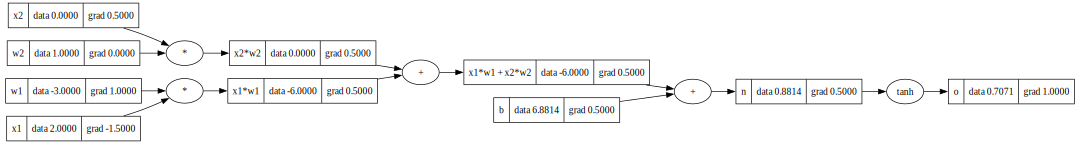

In [120]:
# Esto simplemente automatiza toda la ejecucion hacia atras de los _backwards para cada nodo (usa topological sort)
# ESTO LO METEMOS EN LA CLASE como backward()

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
print(f"topo: {topo}")

# ejecuto 
o.grad = 1.0
for node in reversed(topo):
  node._backward()
draw_dot(o)

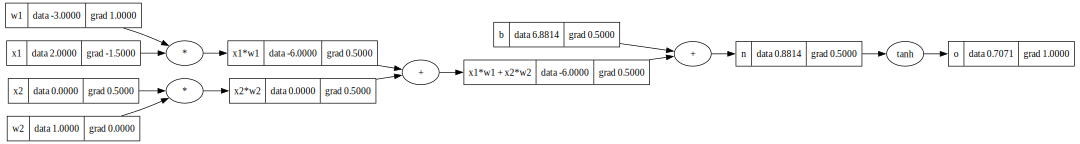

In [122]:
# uso backward()

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


# backward
o.grad = 1.0
o.backward()
draw_dot(o)

#### Con pytorch

pytorch usa Tensors asi que el value nuestro deberia ser un Tensor de 1D

In [123]:
import torch 

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Neural Network

IMPLEMENTO LAS CLASES DE NEURONA, LAYER Y MLP (multilayer perceptron)

### Neural network operations graph

In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  dot.attr(size='15')
  return dot

Value

In [4]:
# aca se añaden varias cosas como isinstance y operaciones:
# power, neg, sub, exp, etc

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



Neuron

In [5]:
# __call__ sirve para cuando queres llamar directamente al objeto

class Neuron:
  
  def __init__(self, nin, id=''): # nin: number of inputs (x)
    self.w = [Value(random.uniform(-1,1), label=f'{id}_W{i}') for i in range(nin)]
    self.b = Value(random.uniform(-1,1), label=f'{id}_b')
  
  def __call__(self, x):
    # a(w * x + b)
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]


In [150]:
# esta es una sola neurona, que inicializa en random values 
neuron = Neuron(2)
print(f"W: {neuron.w}")
print(f"b: {neuron.b}")
print(f"parameters: {neuron.parameters()}")

W: [Value(data=-0.12710654694923607), Value(data=0.631099875217974)]
b: Value(data=0.11541051851447337)
parameters: [Value(data=-0.12710654694923607), Value(data=0.631099875217974), Value(data=0.11541051851447337)]


In [151]:
# y cuando la llamas hace el calculo de la neurona a(w * x + b)
x = [2.0, -1.0]
print(f"Execution with inputs {x} -> {neuron(x)}")

Execution with inputs [2.0, -1.0] -> Value(data=-0.6468727236150762)


Layer

In [6]:
class Layer:
  
  def __init__(self, nin, nout, id=''): # n inputs, n outputs (cantidad de neuronas)
    self.nin = nin
    self.neurons = [Neuron(nin, f"L{id}_n{i}") for i in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons] # ejecuta cada neurona con la data
    return outs[0] if len(outs) == 1 else outs # devuelve los resultados individuales
  
  def parameters(self):
    # para cada neurona te devuelve sus parameters
    return [p for neuron in self.neurons for p in neuron.parameters()]
  

In [153]:
layer = Layer(2,3) # len(x)==2 y hay 3 neuronas
print(f"Neurons in layer: {len(layer.neurons)} -> {layer.neurons}")
print(f"parameters len: {len(layer.parameters())}")

x = [2.0, -1.0]
print(f"Execution with inputs {x} -> {layer(x)}") # uno para cada neuron
for n, o in zip(layer.neurons, layer(x)):
    print(f'- Output of {n} -> {o}')

Neurons in layer: 3 -> [<__main__.Neuron object at 0x13c3128d0>, <__main__.Neuron object at 0x13c2f7390>, <__main__.Neuron object at 0x13c35c510>]
parameters len: 9
Execution with inputs [2.0, -1.0] -> [Value(data=-0.9880904139765776), Value(data=0.7493733218088793), Value(data=0.9844186271991435)]
- Output of <__main__.Neuron object at 0x13c3128d0> -> Value(data=-0.9880904139765776)
- Output of <__main__.Neuron object at 0x13c2f7390> -> Value(data=0.7493733218088793)
- Output of <__main__.Neuron object at 0x13c35c510> -> Value(data=0.9844186271991435)


Multilayer perceptron

In [7]:
class MLP:
  
  def __init__(self, nin, nouts): 
    """n inputs (x), 
    nouts: lista donde la cantidad de elementos es una layer y su value es cantidad de neuronas por layer. El final se cuenta como una layer mas
    """
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1], str(i)) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [155]:
# crea layers con i como input y i+1 como output,
# porque el output de la primera layer es el input size de la segunda y asi
nin = 2
nouts = [3, 4, 2]
sz = [nin] + nouts

layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
for l in layers:
    print(f'{l}: inputs: {l.nin}, neurons: {len(l.neurons)}')

<__main__.Layer object at 0x13c31ab10>: inputs: 2, neurons: 3
<__main__.Layer object at 0x13c5c4a10>: inputs: 3, neurons: 4
<__main__.Layer object at 0x13c5c4fd0>: inputs: 4, neurons: 2


In [156]:
mlp = MLP(nin=2, nouts=[3, 4, 2]) # tres layers, una con 3 otra con 4 y la final con 2 neuronas
layers = mlp.layers

for l in layers:
    print(f'{l}: inputs: {l.nin}, neurons: {len(l.neurons)}')

<__main__.Layer object at 0x13c5c62d0>: inputs: 2, neurons: 3
<__main__.Layer object at 0x13c5c0910>: inputs: 3, neurons: 4
<__main__.Layer object at 0x13c5c1310>: inputs: 4, neurons: 2


In [157]:
x = [2.0, -1.0]
print(f"Execution with inputs {x} -> {mlp(x)}") # devuelve el resultado de la ultima layer

Execution with inputs [2.0, -1.0] -> [Value(data=0.9487975848939891), Value(data=0.3269403367967469)]


In [158]:
x = [2.0001, 3.0002, -1.0003]
y = 1.0
n = MLP(3, [2, 2, 1])
ypred = n(x)

# calculo la loss general
loss = (Value(y)-ypred)**2
print(f"Loss: {loss.data}")

Loss: 2.7511442637170798


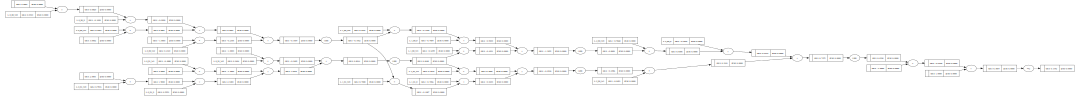

In [136]:
draw_dot(loss)

### Multiple data points

Esto no esta preparado para funcionar por batches sino que hay que hacer un registro por uno

In [13]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

nn = MLP(3, [5,3,2,1])

layers = nn.layers
for l in layers:
    print(f'{l}: inputs: {l.nin}, neurons: {len(l.neurons)}')

<__main__.Layer object at 0x132e24750>: inputs: 3, neurons: 5
<__main__.Layer object at 0x132eee3d0>: inputs: 5, neurons: 3
<__main__.Layer object at 0x132273010>: inputs: 3, neurons: 2
<__main__.Layer object at 0x133029ad0>: inputs: 2, neurons: 1


In [14]:
for x in xs: 
    print(f"Execution with inputs {x} -> {nn(x)}")

Execution with inputs [2.0, 3.0, -1.0] -> Value(data=-0.3128504583783168)
Execution with inputs [3.0, -1.0, 0.5] -> Value(data=-0.48339058098115023)
Execution with inputs [0.5, 1.0, 1.0] -> Value(data=-0.029244742394298816)
Execution with inputs [1.0, 1.0, -1.0] -> Value(data=-0.2621645765767501)


In [15]:
# ejecuto la red para cada uno de los data points y guardo los outputs
ypred = [nn(x) for x in xs] 

# imprimo las predicciones y calculo las losses individuales
for ygt, yout in zip(ys, ypred):
    print(f'target: {ygt}, pred: {yout.data}, loss ({yout.data} - {ygt})**2 = {((yout - ygt)**2).data}')

# calculo la loss general
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # para cada par de posta y predicho calculo el loss y los sumo
print(f"Loss: {loss.data}")

target: 1.0, pred: -0.3128504583783168, loss (-0.3128504583783168 - 1.0)**2 = 1.7235763260641563
target: -1.0, pred: -0.48339058098115023, loss (-0.48339058098115023 - -1.0)**2 = 0.26688529181899345
target: -1.0, pred: -0.029244742394298816, loss (-0.029244742394298816 - -1.0)**2 = 0.9423657701691112
target: 1.0, pred: -0.2621645765767501, loss (-0.2621645765767501 - 1.0)**2 = 1.5930594183651672
Loss: 4.525886806417429


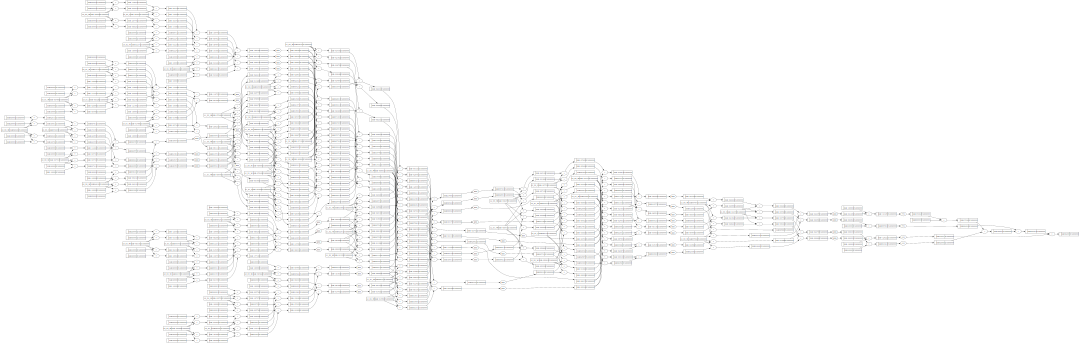

In [16]:
draw_dot(loss)

### Training (gradient descent)

Estructura:
- **forward pass** (ejecucion del modelo hacia adelante) y **calculo de loss** (comparando con el y buscado)
- **backward pass**: inicializa gradientes en 0 y calcula los **gradientes** de cada nodo con **respecto al loss**
- **update**: mueve los nodos por un step size -0.1 para **reducir el loss**


In [140]:
# TRAINING DATA

xs = [
  [2.0011, 3.0012, -1.0013],
  [3.0021, -1.0022, 0.5023],
  [0.5031, 1.0032, 1.0033],
  [1.0041, 1.0042, -1.0043],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Manual

In [141]:
# inicializo la red y muestro la primera loss

n = MLP(3, [4, 4, 1])
layers = n.layers
for l in layers:
    print(f'{l}: inputs: {l.nin}, neurons: {len(l.neurons)}')

<__main__.Layer object at 0x13c374ed0>: inputs: 3, neurons: 4
<__main__.Layer object at 0x13c52da10>: inputs: 4, neurons: 4
<__main__.Layer object at 0x13c52e4d0>: inputs: 4, neurons: 1


Forward pass

In [142]:
# ejecuto la red para cada uno de los data points y guardo los outputs
ypred = [n(x) for x in xs] 

# imprimo las predicciones y calculo las losses individuales
for ygt, yout in zip(ys, ypred):
    print(f'target: {ygt}, pred: {yout.data}, loss ({yout.data} - {ygt})**2 = {((yout - ygt)**2).data}')

# calculo la loss general
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # para cada par de posta y predicho calculo el loss y los sumo
print(f"Loss: {loss.data}")

target: 1.0, pred: -0.9256390242799316, loss (-0.9256390242799316 - 1.0)**2 = 3.7080856518297676
target: -1.0, pred: -0.8624700048378561, loss (-0.8624700048378561 - -1.0)**2 = 0.01891449956929933
target: -1.0, pred: -0.8893905453420756, loss (-0.8893905453420756 - -1.0)**2 = 0.012234451459723428
target: 1.0, pred: -0.8298340166629121, loss (-0.8298340166629121 - 1.0)**2 = 3.3482925285367267
Loss: 7.087527131395516


Backward pass

In [143]:
# para cada uno de los parametros de todo el modelo se inicializa en 0 los gradientes
print({f"Len parameters: {len(n.parameters())}"})
for p in n.parameters():
  p.grad = 0.0

# calculo los gradientes de todos con respecto a la loss
loss.backward()

# veo los gradientes de todos los parametros del modelo
n_parameters = 0
for i, lay in enumerate(n.layers):
  print(f'\nLAYER {i}: ({len(lay.neurons)} neurons, {len(lay.neurons[0].w)} weights each) ----------------------------------')
  for j, neu in enumerate(lay.neurons):
    print(f'   NEURON {j}:')
    for k, w in enumerate(neu.w):
      print(f'      - weight {k}: {w.data} - grad: {w.grad}')
      n_parameters += 1
    for b in [neu.b]:
      print(f'      - bias: {b.data} - grad: {b.grad}')
      n_parameters += 1
print(f'\nLen parameters: {n_parameters}')
  # for p in n.parameters():
  #   print(f"{p} - grad: {p.grad}")

{'Len parameters: 41'}

LAYER 0: (4 neurons, 3 weights each) ----------------------------------
   NEURON 0:
      - weight 0: 0.35657660707652616 - grad: 0.08267701294074338
      - weight 1: 0.35963997019743865 - grad: 0.1186677418166766
      - weight 2: 0.05786914786094721 - grad: -0.11878005387282535
      - bias: 0.1375501098083851 - grad: 0.09707797795720993
   NEURON 1:
      - weight 0: 0.43665845839568473 - grad: -0.513520637197277
      - weight 1: -0.6975599310497691 - grad: -0.5379443221794532
      - weight 2: 0.2992225532533075 - grad: 0.48491685885403746
      - bias: 0.5582068763429264 - grad: -0.48850307809962973
   NEURON 2:
      - weight 0: -0.33927985233434543 - grad: -1.0845798166943392
      - weight 1: 0.04351212961883655 - grad: -1.2527775214941843
      - weight 2: -0.7228180163589397 - grad: 0.9385323125372044
      - bias: -0.4714589432968683 - grad: -0.923937010006578
   NEURON 3:
      - weight 0: -0.2850822512486353 - grad: 0.12063982816710023
      - we

<class '__main__.Value'>


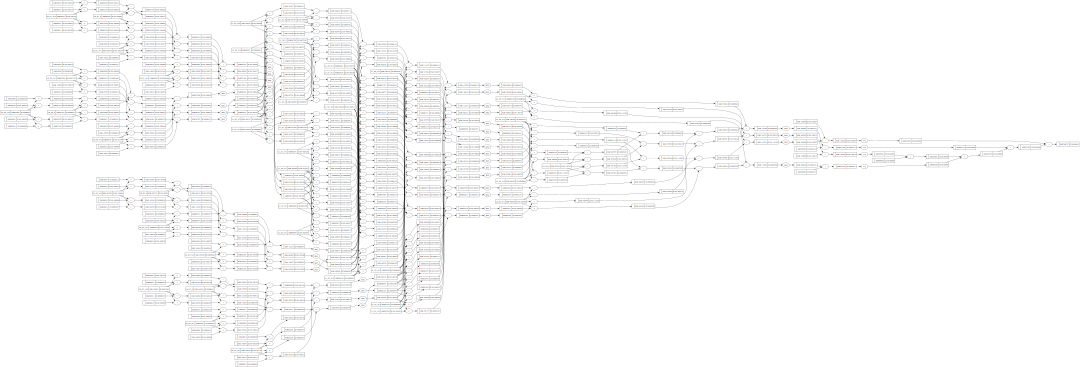

In [144]:
print(type(loss))
draw_dot(loss)

Update

In [145]:
# update
for p in n.parameters():
  print(f'{p} will be increased by (-0.1 * {p.grad}) = {-0.1 * p.grad} ---> {p.data + -0.1 * p.grad}')
  p.data += -0.1 * p.grad # se actualizan todos los parametros para bajar la loss

Value(data=0.35657660707652616) will be increased by (-0.1 * 0.08267701294074338) = -0.008267701294074338 ---> 0.3483089057824518
Value(data=0.35963997019743865) will be increased by (-0.1 * 0.1186677418166766) = -0.01186677418166766 ---> 0.347773196015771
Value(data=0.05786914786094721) will be increased by (-0.1 * -0.11878005387282535) = 0.011878005387282536 ---> 0.06974715324822975
Value(data=0.1375501098083851) will be increased by (-0.1 * 0.09707797795720993) = -0.009707797795720993 ---> 0.1278423120126641
Value(data=0.43665845839568473) will be increased by (-0.1 * -0.513520637197277) = 0.051352063719727704 ---> 0.48801052211541246
Value(data=-0.6975599310497691) will be increased by (-0.1 * -0.5379443221794532) = 0.053794432217945325 ---> -0.6437654988318238
Value(data=0.2992225532533075) will be increased by (-0.1 * 0.48491685885403746) = -0.04849168588540375 ---> 0.25073086736790373
Value(data=0.5582068763429264) will be increased by (-0.1 * -0.48850307809962973) = 0.048850307

In [146]:
########## nuevo forward pass

# ejecuto la red para cada uno de los data points y guardo los outputs
ypred = [n(x) for x in xs] 

# imprimo las predicciones y calculo las losses individuales
for ygt, yout in zip(ys, ypred):
    print(f'target: {ygt}, pred: {yout.data}, loss ({yout.data} - {ygt})**2 = {((yout - ygt)**2).data}')

# calculo la loss general
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # para cada par de posta y predicho calculo el loss y los sumo
print(f"Loss: {loss.data}")

target: 1.0, pred: -0.5418007591278872, loss (-0.5418007591278872 - 1.0)**2 = 2.3771495808473286
target: -1.0, pred: -0.7483945095480994, loss (-0.7483945095480994 - -1.0)**2 = 0.06330532282554145
target: -1.0, pred: -0.7745295212973655, loss (-0.7745295212973655 - -1.0)**2 = 0.05083693676639515
target: 1.0, pred: -0.344337544534904, loss (-0.344337544534904 - 1.0)**2 = 1.807243433646135
Loss: 4.2985352740854


Iterativo

In [13]:
# TRAINING DATA

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [17]:
# inicializo la red y muestro la primera loss

n = MLP(3, [4, 4, 1])
layers = n.layers
for l in layers:
    print(f'{l}: inputs: {l.nin}, neurons: {len(l.neurons)}')

<__main__.Layer object at 0x131c8f400>: inputs: 3, neurons: 4
<__main__.Layer object at 0x131c8f8e0>: inputs: 4, neurons: 4
<__main__.Layer object at 0x131c8f640>: inputs: 4, neurons: 1


In [18]:
iterations = 100
losses = []

for k in range(iterations):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  losses.append(loss.data)
  if iterations <= 20:
    print(k, loss.data)

for ygt, yout in zip(ys, ypred):
    print(f'target: {ygt}, pred: {yout.data}, loss ({yout.data} - {ygt})**2 = {((yout - ygt)**2).data}')

# import matplotlib.pyplot as plt
# plt.plot(losses)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Loss Across Iterations')
# plt.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(iterations)), y=losses, mode='lines', name='Loss'))
fig.update_layout(
    title='Loss Across Iterations',
    xaxis_title='Iteration',
    yaxis_title='Loss')
fig.show()

target: 1.0, pred: 0.9757537925542993, loss (0.9757537925542993 - 1.0)**2 = 0.0005878785754999529
target: -1.0, pred: -0.9879135483508881, loss (-0.9879135483508881 - -1.0)**2 = 0.00014608231346632046
target: -1.0, pred: -0.956627762515848, loss (-0.956627762515848 - -1.0)**2 = 0.0018811509843816778
target: 1.0, pred: 0.9613676738423026, loss (0.9613676738423026 - 1.0)**2 = 0.0014924566243547112


## Analyzing mini-batch

COMO SE CALCULAN LOS GRADIENTES PARA EL MISMO WEIGHT PERO EN UN MINI BATCH DE DATOS????



**Explicando derivadas y gradientes**


Aquí va el **back-prop completo, nodo por nodo**, usando tu grafo:

```
x1=3 ──*──► a1 ──+──► y1 ──┐
                 ^         |
w=2 ─────────────┘         |
                           +──► L   (loss = y1 + y2)
w=2 ─────────────┐         |
                 v         |
x2=4 ──*──► a2 ──+──► y2 ──┘
b=1 ─────────────┴─────────┘   (b se usa en las dos +)
```

| etiqueta | definición    |  valor |
| -------- | ------------- | -----: |
| x₁       | dato 1        |      3 |
| x₂       | dato 2        |      4 |
| w        | **parámetro** |      2 |
| b        | **parámetro** |      1 |
| a₁       | w × x₁        |      6 |
| a₂       | w × x₂        |      8 |
| y₁       | a₁ + b        |      7 |
| y₂       | a₂ + b        |      9 |
| **L**    | y₁ + y₂       | **16** |

---

**Retro-propagación detallada**

> Notación ∂L/∂n = “gradiente de la loss respecto al nodo *n*”.
> El símbolo **∇** (nabla) es simplemente “vector de todas esas derivadas”.

| paso | nodo        | regla local | entrada(s) | cálculo                                     | gradiente que se **acumula**            |
| ---- | ----------- | ----------- | ---------- | ------------------------------------------- | --------------------------------------- |
| 0    | **L**       | final       | —          | ∂L/∂L = 1                                   | L.grad = 1                              |
| 1    | `sum` (L)   | L = y₁ + y₂ | y₁, y₂     | ∂L/∂y₁ = 1 · 1<br>∂L/∂y₂ = 1 · 1            | y₁.grad = 1<br>y₂.grad = 1              |
| 2    | `add1` (y₁) | y₁ = a₁ + b | a₁, b      | ∂L/∂a₁ = 1 · 1 = 1<br>∂L/∂b  = 1 · 1 = 1    | a₁.grad = 1<br>b.grad = **1**           |
| 3    | `add2` (y₂) | y₂ = a₂ + b | a₂, b      | ∂L/∂a₂ = 1 · 1 = 1<br>∂L/∂b  = 1 · 1 = 1    | a₂.grad = 1<br>b.grad = **2** (se suma) |
| 4    | `mul1` (a₁) | a₁ = w·x₁   | w, x₁      | ∂L/∂w  = 1 · x₁ = 3<br>(∂L/∂x₁ = 1 · w = 2) | w\.grad = **3**                         |
| 5    | `mul2` (a₂) | a₂ = w·x₂   | w, x₂      | ∂L/∂w  = 1 · x₂ = 4<br>(∂L/∂x₂ = 1 · w = 2) | w\.grad = **7** (3 + 4)                 |

**Gradientes finales sobre los parámetros**

$$
\nabla_w L = 7 ,\qquad
\nabla_b L = 2
$$

---

**Por qué **w** y **b** “aparecen dos veces” pero tienen un solo `.grad`**

* **Un mismo objeto** (`Value`, `Tensor`, etc.) representa cada parámetro.
* En el grafo se crean **dos aristas** que parten de ese mismo nodo; durante `backward()` cada arista envía su contribución y la librería hace `param.grad += contrib`.
* Así obtenés la **suma total** de todos los caminos que conectan la loss con ese parámetro.

---


In [7]:
import math, random
from graphviz import Digraph
from IPython.display import display

# -------------------- micrograd (minimal) --------------------------
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data  = float(data)
        self.grad  = 0.0
        self._prev = set(_children)
        self._op   = _op
        self.label = label
        self._backward = lambda: None

    # operations
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    __radd__ = __add__

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    __rmul__ = __mul__

    # backward
    def backward(self):
        topo, visited = [], set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)
        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# -------------------- graph helpers --------------------------------
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, highlight=None):
    """Return a Digraph; `highlight` is an optional set of nodes to color."""
    highlight = highlight or set()
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        style = {'shape': 'record'}
        # color active node
        if n in highlight:
            style['style'] = 'filled'
            style['fillcolor'] = 'lightyellow'
            style['color'] = 'red'
            style['penwidth'] = '2'
        dot.node(uid,
                 label=f'{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}',
                 **style)
        if n._op:
            dot.node(uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    dot.attr(size='12')
    return dot

def backward_step_by_step(root):
    """Yield (step_idx, node_processed, dot)"""
    topo, visited = [], set()
    def build(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build(child)
            topo.append(v)
    build(root)

    root.grad = 1.0
    yield (-1, None, draw_dot(root, highlight={root}))

    for i, node in enumerate(reversed(topo)):
        node._backward()
        yield (i, node, draw_dot(root, highlight={node}))


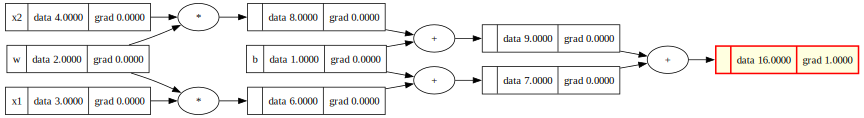

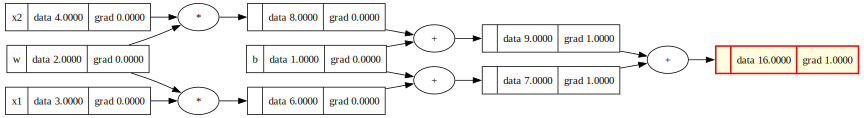

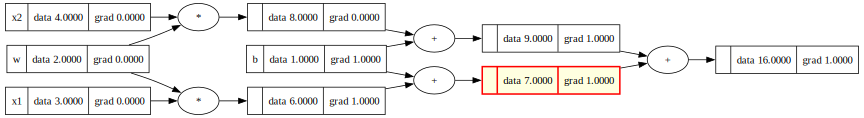

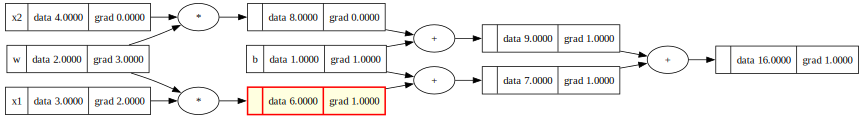

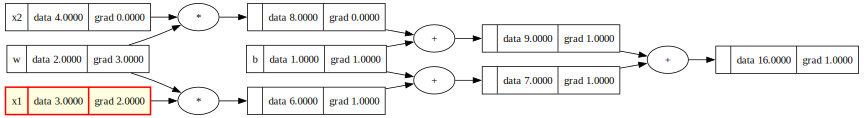

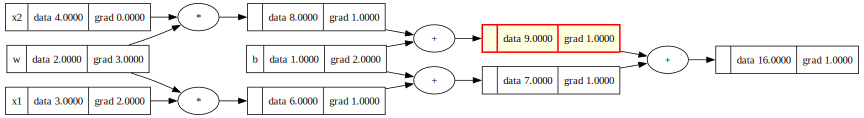

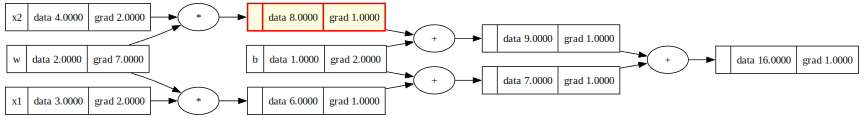

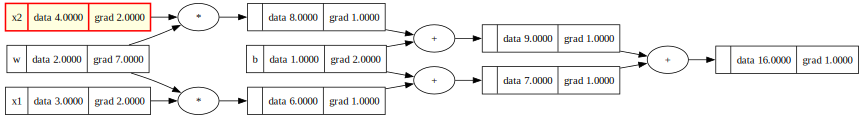

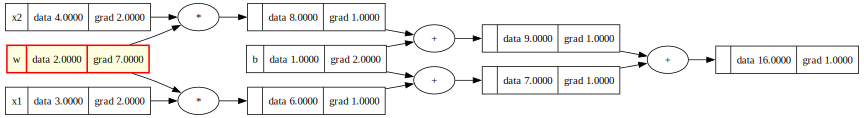

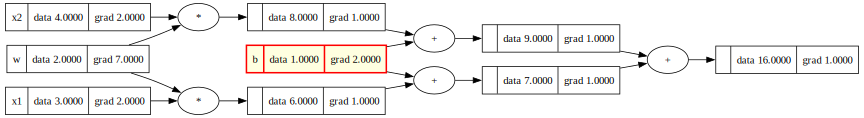

In [8]:
# -------------------- simple example -------------------------------
w = Value(2.0, label='w')
b = Value(1.0, label='b')
x1 = Value(3.0, label='x1')
x2 = Value(4.0, label='x2')

y1 = w * x1 + b
y2 = w * x2 + b
L  = y1 + y2

# Display step-by-step with active node highlighted
for idx, node, dot in backward_step_by_step(L):
    caption = f"Step {idx}: {'seed (L)' if node is None else f'backward through {node.label or node._op or str(node)}'}"
    display(dot, metadata={'caption': caption})

**Explicando el backpropagation**


**La regla de la cadena **exige** que las contribuciones que llegan por caminos distintos se **sumen****

Supongamos que un nodo $z$ alimenta a **dos** operaciones distintas:

```
z  ──► y1 = f₁(z, …)
 \              \
  \              ► … L
   \
    └─► y2 = f₂(z, …)
```

La loss final $L$ depende de $z$ **a través de dos rutas**:
$z \rightarrow y_1 \rightarrow L$ y $z \rightarrow y_2 \rightarrow L$.

Regla de la cadena para una variable que afecta al resultado por varios caminos:

$$
\frac{\partial L}{\partial z}
\;=\;
\frac{\partial L}{\partial y_1}\,
\frac{\partial y_1}{\partial z}
\;+\;
\frac{\partial L}{\partial y_2}\,
\frac{\partial y_2}{\partial z}
$$

La **suma** es obligatoria: cada rama mide “qué tan rápido cambia $L$ si modifico $z$ a través de ese camino”, y luego las juntamos porque ambas alteraciones ocurren simultáneamente cuando mueves $z$.

---

**Cálculo manual**

1. $y_1 = 2z        \;\Rightarrow\; \partial y_1/\partial z = 2$
2. $y_2 = z^2       \;\Rightarrow\; \partial y_2/\partial z = 2z = 6$
3. $\partial L/\partial y_1 = 1,\; \partial L/\partial y_2 = 1$

$$
\frac{\partial L}{\partial z}
  = 1·2 + 1·6 = 8
$$

**Salida del código**

`dL/dz = 8.0` ✅ — la suma aparece exactamente como predice la teoría.

---

**Resumen**

* Matemáticamente, **la derivada total respecto a un nodo es la suma de
  las derivadas parciales de todas las rutas** que conectan ese nodo con
  la loss.
* Implementacionalmente, el patrón `param.grad += …` en cada `_backward`
  materializa esa suma.
* Cualquier framework de autodiferenciación (PyTorch, JAX, TensorFlow,
  tu `Value`) obedece a la misma regla esencial.


**Comprobar numericamente por que se suman las derivadas cuando vienen por distintas ramas**

In [2]:
import numpy as np

# -------- problem setup ----------
x1, x2 = 3.0, 4.0        # batch inputs
w,  b  = 2.0, 1.0        # parameters
h      = 1e-6            # finite-difference step

def loss(w, b):
    """L = (w*x1 + b) + (w*x2 + b)"""
    return w*x1 + b + w*x2 + b        #  = w*(x1+x2) + 2*b

# -------- total gradients ----------
L0  = loss(w, b)
dw  = (loss(w + h, b) - L0) / h       # dL/dw  ≈ 7
db  = (loss(w, b + h) - L0) / h       # dL/db  ≈ 2
print(f"dL/dw ≈ {dw:.6f}")
print(f"dL/db ≈ {db:.6f}")

# -------- per-branch contributions ----------
def branch1(w, b):          # y1 = w*x1 + b
    return w*x1 + b
def branch2(w, b):          # y2 = w*x2 + b
    return w*x2 + b

dw1 = (branch1(w + h, b) - branch1(w, b)) / h   # ≈ x1 = 3
dw2 = (branch2(w + h, b) - branch2(w, b)) / h   # ≈ x2 = 4
db1 = (branch1(w, b + h) - branch1(w, b)) / h   # ≈ 1
db2 = (branch2(w, b + h) - branch2(w, b)) / h   # ≈ 1

print("\nPer-branch finite differences")
print(f"  branch1  dL1/dw ≈ {dw1:.6f},  dL1/db ≈ {db1:.6f}")
print(f"  branch2  dL2/dw ≈ {dw2:.6f},  dL2/db ≈ {db2:.6f}")
print(f"  sum      dw ≈ {dw1+dw2:.6f},   db ≈ {db1+db2:.6f}")


dL/dw ≈ 7.000000
dL/db ≈ 2.000000

Per-branch finite differences
  branch1  dL1/dw ≈ 3.000000,  dL1/db ≈ 1.000000
  branch2  dL2/dw ≈ 4.000000,  dL2/db ≈ 1.000000
  sum      dw ≈ 7.000000,   db ≈ 2.000000


# Backprop manually

https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=5

https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok biolerplate done, now we get to the action:

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3377, grad_fn=<NegBackward0>)

In [ ]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
    
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3377387523651123 diff: 2.384185791015625e-07


In [ ]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


In [ ]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [ ]:
F.softmax(logits, 1)[0]

tensor([0.0719, 0.0881, 0.0193, 0.0493, 0.0169, 0.0864, 0.0226, 0.0356, 0.0165,
        0.0314, 0.0364, 0.0383, 0.0424, 0.0279, 0.0317, 0.0142, 0.0085, 0.0195,
        0.0152, 0.0555, 0.0450, 0.0236, 0.0250, 0.0662, 0.0616, 0.0269, 0.0239],
       grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0] * n

tensor([ 0.0719,  0.0881,  0.0193,  0.0493,  0.0169,  0.0864,  0.0226,  0.0356,
        -0.9835,  0.0314,  0.0364,  0.0383,  0.0424,  0.0279,  0.0317,  0.0142,
         0.0085,  0.0195,  0.0152,  0.0555,  0.0450,  0.0236,  0.0250,  0.0662,
         0.0616,  0.0269,  0.0239], grad_fn=<MulBackward0>)

In [ ]:
dlogits[0].sum()

tensor(1.3970e-09, grad_fn=<SumBackward0>)

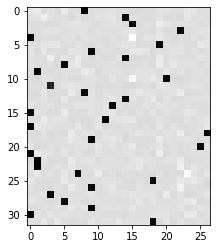

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7805
  10000/ 200000: 2.1775
  20000/ 200000: 2.3957
  30000/ 200000: 2.5032
  40000/ 200000: 2.0065
  50000/ 200000: 2.3873
  60000/ 200000: 2.3378
  70000/ 200000: 2.0640
  80000/ 200000: 2.3497
  90000/ 200000: 2.1093
 100000/ 200000: 1.9132
 110000/ 200000: 2.2229
 120000/ 200000: 1.9912
 130000/ 200000: 2.4441
 140000/ 200000: 2.3198
 150000/ 200000: 2.1857
 160000/ 200000: 2.0296
 170000/ 200000: 1.8391
 180000/ 200000: 2.0436
 190000/ 200000: 1.9200


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070523500442505
val 2.109893560409546


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khi.
mreigeet.
khalaysie.
mahnen.
delynn.
jareen.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinn.
shoison.
jadiquintero.
dearyxi.
jace.
pinsley.
dae.
iia.
